In [61]:
import cv2
import torch
import os
from PIL import Image

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [62]:
model = torch.hub.load('ultralytics/yolov5', 'custom', '../models/yoloFire.pt')  # force_reload=True to update

Using cache found in C:\Users\vikas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-5-25 Python-3.10.4 torch-2.2.1+cpu CPU

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7246518 parameters, 0 gradients
Adding AutoShape... 


In [63]:
def yolo(im, yolo_frame, size=640):
    g = (size / max(im.size))  
    im = im.resize((int(x * g) for x in im.size), Image.LANCZOS)
    results = model(im)
    
    result_image = Image.fromarray(results.ims[0])
    result_frame = np.array(result_image)
    
#     results.render()  -> YOLO Inference

    for box in results.xyxy[0]:
        xmin, ymin, xmax, ymax, _, _ = box
        cv2.rectangle(result_frame, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 2)
        cv2.rectangle(yolo_frame, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 0, 255), -1)
        
                
    area = 0
    gray = cv2.cvtColor(yolo_frame, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate through each contour
    for contour in contours:
        # Calculate area of the contour
        pixel_area = cv2.contourArea(contour)  # Area in pixels

        area += pixel_area
            # Draw contour on the original image
#             cv2.drawContours(black_frame, [contour], -1, (0, 255, 0), 1)
        
#         pr = area*100/(black_frame.shape[0]*black_frame.shape[1])
        
#         cv2.putText(black_frame, "Area: {}%".format(round(pr,2)), (20, 370), font, font_scale, text_color, font_thickness, lineType=cv2.LINE_AA)
    
#     return black_frame

    

    return result_frame, yolo_frame, results, area

In [64]:
start_frame = 1000  # Change this to the frame number you want to start from

cap = cv2.VideoCapture('../demoVideos/smoke&fire.mp4')
# cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

_, old_frame = cap.read()

#### variables for yolo #####
yolo_area_frame = np.zeros_like(old_frame)
old_area = 0
areas = []
area_growth = []

#### variables for motion #####
# -> -> - > Clockwise positive direction
motion_frame = np.zeros_like(old_frame)
prvs = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
avgx = []
avgy = []
angles = []
speed = []

while True:
    # Read a frame from the video
    ret, new_frame = cap.read()
    
    # Break the loop if the video is over
    if not ret:
        print('Error in capturing frames')
        break
    
    # Convert the frame from OpenCV format (BGR) to PIL format (RGB)
    frame_pil = Image.fromarray(cv2.cvtColor(new_frame, cv2.COLOR_BGR2RGB))
    
    # Area analysis using YOLO
    yolo_result_frame, yolo_frame, yolo_results, new_area = yolo(frame_pil, yolo_area_frame)
    areas.append(new_area)
    area_growth.append(new_area-old_area)
    old_area = new_area
    
    cv2.imshow('YOLOv5 result', yolo_result_frame)
    

    # Motion analysis using Farneback
    new = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
    
    flow, motion_frame = motion(motion_frame, prvs, new)
    
    cv2.imshow('Motion analysis', motion_frame)
    
    prvs = new
    
    # Get average flow direction
    avgx.append(np.mean(flow[..., 0]))
    avgy.append(np.mean(flow[..., 1]))


    if len(avgx) > 30: 
        avg_fx = np.mean(avgx)
        avg_fy = np.mean(avgy)
        avg_direction_angle = np.arctan2(avg_fy, avg_fx)
        avg_direction_degrees = np.degrees(avg_direction_angle)
        
        avg_speed = np.sqrt(avg_fx**2 + avg_fy**2)
        
        speed.append(avg_speed)
        
        angles.append(avg_direction_degrees)

        # Set text on black_frame
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(new_frame, f"Direction wrt X+: {avg_direction_degrees:.2f} degrees", (10, 30), font, 1, (0, 255, 0), 1, cv2.LINE_AA)

        avgx.pop(0)
        avgy.pop(0)
        
    cv2.imshow('Frame', new_frame)
    
    # Press q to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

NameError: name 'motion' is not defined

In [65]:
cap.release()
cv2.destroyAllWindows()

### Code to plot metrics

In [60]:
from sklearn.preprocessing import MinMaxScaler

# area_scaler = MinMaxScaler()
# areas_normalized = area_scaler.fit_transform(np.array(areas).reshape(-1, 1)).flatten()

# growth_scaler = MinMaxScaler()
# area_growth_normalized = growth_scaler.fit_transform(np.array(area_growth).reshape(-1, 1)).flatten()

# speed_scaler = MinMaxScaler()
# speed_normalized = speed_scaler.fit_transform(np.array(speed).reshape(-1, 1)).flatten()

cap = cv2.VideoCapture('../demoVideos/paperFire1.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)

# Generate the x-axis values in seconds
frame_numbers = np.arange(len(areas))  # Assuming areas, area_growth, speed all have the same length
time_seconds = frame_numbers / fps

# Plotting
plt.figure(figsize=(12, 8))


# Plot for areas
plt.subplot(2, 2, 1)
sns.lineplot(x=time_seconds, y=areas, color='b', linewidth=1)
plt.ylabel('Area (pixels)', fontsize=12)
plt.xlabel('Time (seconds)', fontsize=12)
plt.title(f'Area (Min: {min(areas):.2f}, Max: {max(areas):.2f}, Dev: {np.std(areas):.2f})')

# Plot for area growth
plt.subplot(2, 2, 3)
sns.lineplot(x=time_seconds, y=area_growth, color='r', linewidth=1)
plt.ylabel('Growth (pixels)', fontsize=12)
plt.xlabel('Time (seconds)', fontsize=12)
plt.title(f'Growth (Min: {min(area_growth):.2f}, Max: {max(area_growth):.2f}, Dev: {np.std(area_growth):.2f})')

# Plot for speed
plt.subplot(2, 2, 2)
sns.lineplot(x=time_seconds[:632], y=speed, color='g', linewidth=1)
plt.ylabel('Speed (pixels)', fontsize=12)
plt.xlabel('Time (seconds)', fontsize=12)
plt.title(f'Speed (Min: {min(speed):.2f}, Max: {max(speed):.2f}, Dev: {np.std(speed):.2f})')

# Plotting polar plot in the second column
plt.subplot(2, 2, 4, polar=True)
plt.hist(np.radians(angles), bins=30, color='skyblue', alpha=0.7)
plt.xlabel('Direction', fontsize=12)
plt.gca().set_theta_direction(-1)
plt.gca().set_rticks([])
plt.title('Direction')

# Optionally, adjust the spacing between subplots
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.4)

print(plt)

plt.savefig('fire_metrics.png')

ValueError: min() arg is an empty sequence

## All Functions for Website 4.0

In [1]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# Seven Rules for Segmentation -> https://core.ac.uk/download/pdf/55305301.pdf
def fire_pixel_segmentation(im):
    fire_mask = np.zeros_like(im[:, :, 0])
    
    # YCbCr Color Space and splitting BGR Channel
    YCrCb_im = cv2.cvtColor(im, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(YCrCb_im)
    B, G, R = cv2.split(im)
    
    # Rule 1: R > G > B
    mask1 = (R > G) & (G > B)
    
    # Rule 2: R > 190 & G > 100 & B < 140
    mask2 = (R > 190) & (G > 100) & (B < 140)
    
    # Rule 3 & 4: Y >= Cb & Cr >= Cb
    mask3_4 = (Y >= Cb) & (Cr >= Cb)
    
    # Rule 5: Y >= Ymean & Cb <= Cbmean & Cr >= Crmean
    mask5 = (Y >= np.mean(Y)) & (Cb <= np.mean(Cb)) & (Cr >= np.mean(Cr))
    
    # Rule 6: Cb-Cr >= 70 (Threshold)
    mask6 = abs(Cb-Cr) >= 70
    
    # Rule 7: Cb <= 120 & Cr >= 150
    mask7 = (Cb <= 120) & (Cr >= 150)

    combined_mask = mask1 & mask2 & mask3_4 & mask5 & mask6 & mask7
    fire_mask[combined_mask] = 255
    
    kernel = np.ones((3, 3), np.uint8)
    eroded_mask = cv2.erode(fire_mask, kernel, iterations=1)
    fire_mask = cv2.dilate(eroded_mask, kernel, iterations=1)
    
    return fire_mask

In [16]:
def fire_flow(fire_mask, area_frame, fireX, fireY, processed_frame):
    
    centerX = []
    centerY = []
    contours, _ = cv2.findContours(fire_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    cv2.drawContours(processed_frame, contours, -1, (0, 0, 255), 2) 
    
    for contour in contours:
        area = cv2.contourArea(contour)
        # Compute the moments of the contour
        M = cv2.moments(contour)
        if M["m00"] != 0 and area > 100:
            # Calculate the center of the contour
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            
            centerX.append(cX)
            centerY.append(cY)
            
    fireX.append(np.mean(centerX))
    fireY.append(np.mean(centerY))
    
    endpoint_mframes = None
    if len(fireX) > 180:
        x = np.nanmean(fireX)
        y = np.nanmean(fireY)
        
        if np.isfinite(x) and np.isfinite(y):
            endpoint_mframes = (int(x), int(y))
 
        fireX.pop(0)
        fireY.pop(0)
        
    total_area = 0
    cv2.drawContours(area_frame, contours, -1, (0, 0, 255), -1) 
    binary_image = cv2.cvtColor(area_frame, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(binary_image, 50, 255, cv2.THRESH_BINARY)
    
    area_contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in area_contours:
        total_area += cv2.contourArea(contour)  
    
    return total_area, area_frame, processed_frame, endpoint_mframes

In [17]:
def smoke_pixel_segmentation(im):

    hsv_im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    lower_bound = np.array([0, 50, 0], dtype=np.uint8)
    upper_bound = np.array([180, 200, 255], dtype=np.uint8)
    
    mask = cv2.inRange(hsv_im, lower_bound, upper_bound)
    invert_mask = cv2.bitwise_not(mask)
        
    kernel = np.ones((3, 3), np.uint8)
    eroded_mask = cv2.erode(invert_mask, kernel, iterations=1)
    smoke_mask = cv2.dilate(eroded_mask, kernel, iterations=1)
    
    return smoke_mask

In [18]:
def smoke_flow(im, prev, smoke_mask, wind_dir, processed_frame):
    smoke_frame = im.copy()
    curr = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
#     pyr_scale, levels, winsize, iterations, poly_n, poly_sigma
    flow = cv2.calcOpticalFlowFarneback(prev, curr, None, 
                                        0.5, 3, 15, 5, 3, 1.5, 0)
    
    # Get average flow direction
    avgx = []
    avgy = []
     
    step = 15
    for y in range(0, processed_frame.shape[0], step):
        for x in range(0, processed_frame.shape[1], step):
            if smoke_mask[y, x] > 0:
                fx, fy = flow[y, x]
                flow_magnitude = np.sqrt(fx**2 + fy**2)
                
                if flow_magnitude > 0.5:
                    avgx.append(fx)
                    avgy.append(fy)

                    end_point = (int(x + fx), int(y + fy))
                    cv2.arrowedLine(processed_frame, (x, y), end_point, (255, 0, 0), 2, tipLength=3)

    avg_direction_angle = np.arctan2(np.mean(avgy), np.mean(avgx))
    wind_dir.append(np.degrees(avg_direction_angle))
        
    smoke_dir_nframes = None
    if len(wind_dir) > 30:
        smoke_dir_nframes = np.nanmean(wind_dir)
        wind_dir.pop(0)
    
    return curr, processed_frame, smoke_dir_nframes

In [21]:
def graph(time_seconds, areas, smoke_dir, points):
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(2, 2, width_ratios=[2, 1], hspace=0.3, wspace=0.3)

    # First subplot: Cumulative Area over Time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(time_seconds, areas, label='Burned Area', color='firebrick')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Cumulative Area (pixel units)')
    ax1.set_title('Cumulative Burned Area Over Time')
    ax1.grid(True)
    ax1.legend()

    # Second subplot: Change in Area over Time
    area_growth = [areas[i+2] - areas[i+1] for i in range(len(areas) - 2)]
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(time_seconds[2:], area_growth, label='Area Change', color='orangered')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Change in Area (pixel units)')
    ax2.set_title('Rate of Area Change Over Time')
    ax2.grid(True)
    ax2.legend()

    # Third subplot: Smoke Direction
    ax3 = fig.add_subplot(gs[0, 1], polar=True)
    ax3.hist(np.radians(smoke_dir), bins=30, color='steelblue', alpha=0.7)
    ax3.set_title('Smoke Dispersion Direction')
    ax3.set_theta_direction(-1)
    ax3.set_rticks([]) 

    # Fourth subplot: Fire Spread Path
    ax4 = fig.add_subplot(gs[1, 1])
    x, y = zip(*points)
    ax4.plot(x, y, marker='o', color='darkorange', markersize=5, linestyle='-', label='Fire Path')
    ax4.invert_yaxis()

    # Add star markers for the start and end points
    ax4.plot(x[0], y[0], marker='*', color='limegreen', markersize=12, label='Ignition Point')
    ax4.plot(x[-1], y[-1], marker='*', color='red', markersize=12, label='Current Fire Front')

    ax4.set_xlabel('X Coordinate')
    ax4.set_ylabel('Y Coordinate')
    ax4.set_title('Fire Spread Path')
    ax4.grid(True)
    ax4.legend()

#     plt.tight_layout()
#     plt.savefig('forest_fire_analysis1.png', dpi=300, bbox_inches='tight')

C:\Users\vikas\AppData\Local\Temp\ipykernel_5456\2581402400.py:26: RuntimeWarning: Mean of empty slice
  x = np.nanmean(fireX)
C:\Users\vikas\AppData\Local\Temp\ipykernel_5456\2581402400.py:27: RuntimeWarning: Mean of empty slice
  y = np.nanmean(fireY)


No frames to process


ValueError: not enough values to unpack (expected 2, got 0)

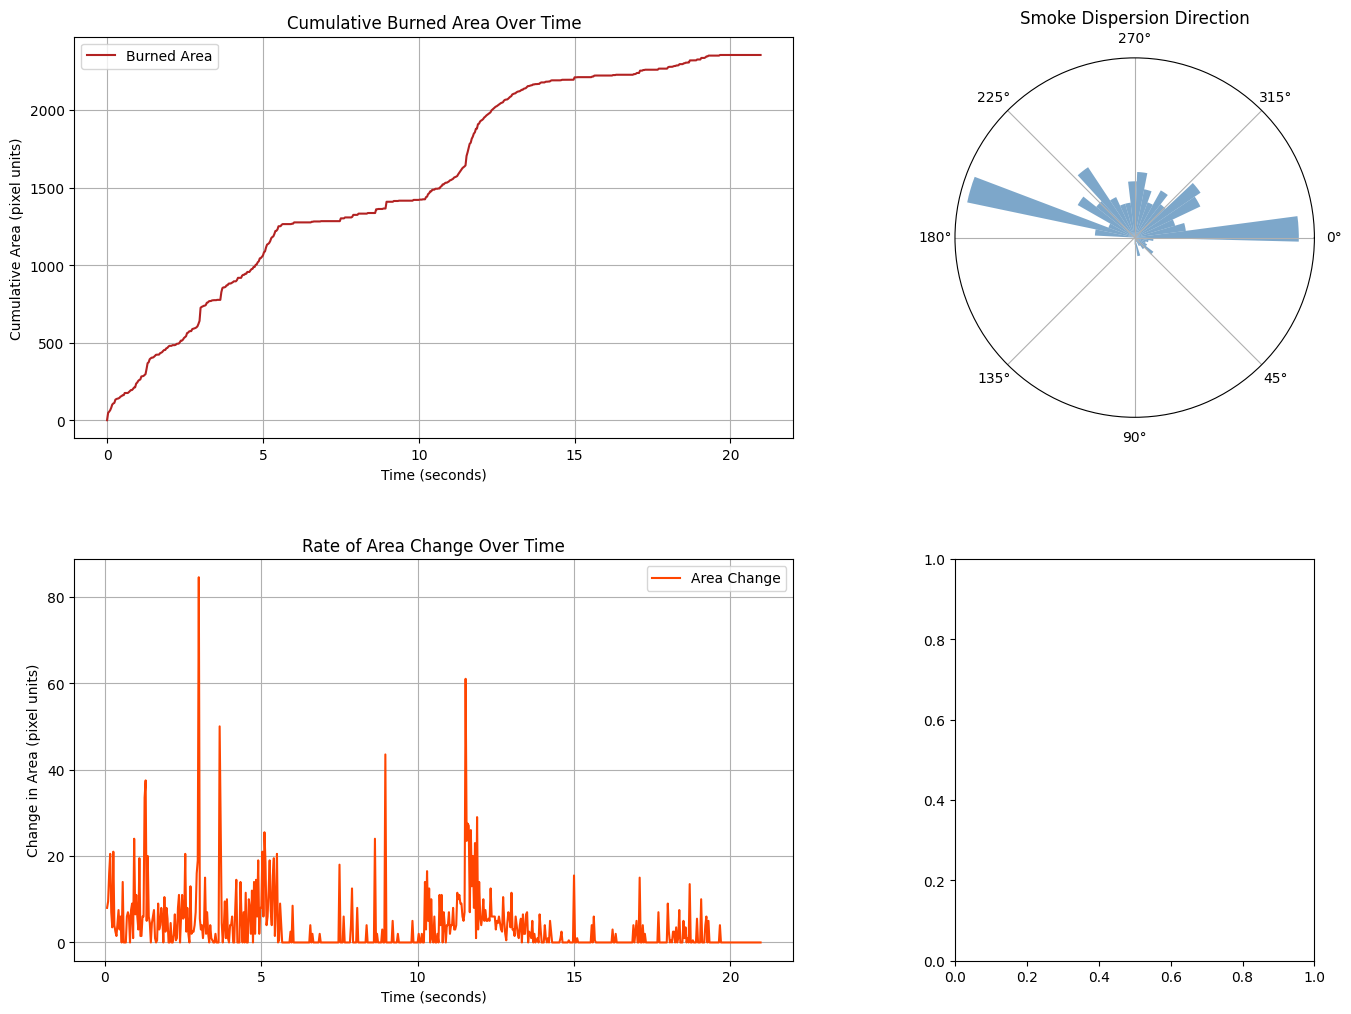

In [27]:
size_factor = 1
cap = cv2.VideoCapture('../testVideos/test3.mp4')
fps = math.ceil(cap.get(cv2.CAP_PROP_FPS))
# cap.set(cv2.CAP_PROP_POS_FRAMES, 2000)

_, first_frame = cap.read()

height, width = first_frame.shape[:2]
new_width = width // size_factor
new_height = height // size_factor

first_frame = cv2.resize(first_frame, (new_width, new_height))

# Fire Flow
area_frame = np.zeros_like(first_frame)
areas = [0]
fireX = []
fireY = []
path = []

# Smoke Optical Flow
prev = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
wind_dir = []
smoke_dir = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print('No frames to process')
        break
        
    im = cv2.resize(frame, (new_width, new_height))
    processed_frame = im.copy()
    
    #######################################
    fire_mask = fire_pixel_segmentation(im)
    area, new_area_frame, processed_frame, end_point = fire_flow(fire_mask, area_frame, fireX, fireY, processed_frame)
    area_frame = new_area_frame
        
    if end_point != None:
        path.append(end_point)

    areas.append(area)
    
    #########################################
    smoke_mask = smoke_pixel_segmentation(im)
    curr, processed_frame, smoke = smoke_flow(im, prev, smoke_mask, wind_dir, processed_frame)
    prev = curr
    
    if smoke != None:
        smoke_dir.append(smoke)
    
    if len(path) > 2:
        start_point = path[0]
        end_point = path[-1]
        cv2.arrowedLine(processed_frame, start_point, end_point, (0, 255, 0), 2, tipLength=0.5)
        
    cv2.imshow('Frame', im)
    
    cv2.imshow('Fire mask', fire_mask)
    cv2.imshow('Smoke mask', smoke_mask)
    cv2.imshow('Fire flow', processed_frame)
    
        
    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()


points = []
seen = set()

for item in path:
    if item not in seen:
        points.append(item)
        seen.add(item)

frame_numbers = np.arange(len(areas))  
time_seconds = frame_numbers / fps
graph(time_seconds, areas, smoke_dir, points)

In [58]:
cap.release()
cv2.destroyAllWindows()